# Project 1g: using real-world geographic data

In [15]:
import numpy as np
from imageio.v3 import imread
import matplotlib.pyplot as plt
# from matplotlib import cm
import numpy as np
import pandas as pd

from scipy.stats import normaltest

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [16]:
# Loading the terrain data
terrain1 = imread('SRTM_data_Norway_1.tif')
terrain2 = imread('SRTM_data_Norway_2.tif')
print(type(terrain1), terrain1.shape, terrain2.shape)

<class 'numpy.ndarray'> (3601, 1801) (3601, 1801)


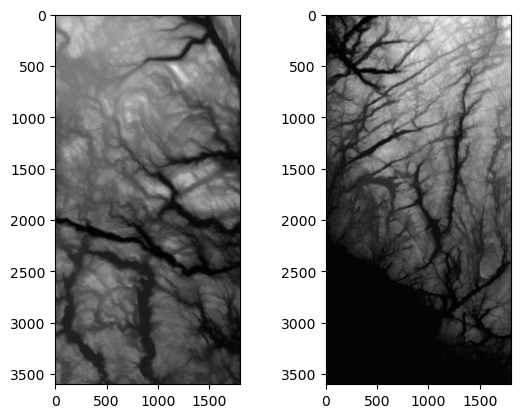

In [3]:
# Plotting the terrains
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(terrain1, cmap="gray")
ax[1].imshow(terrain2, cmap="gray")
plt.show()

In [4]:
# Splitting the data from terrain1 into train / test
index_vals = np.array(range(np.prod(terrain1.shape)))
print(index_vals.shape)

terrain1_values = terrain1.flatten()

idx_train, idx_test = train_test_split(index_vals, test_size=.20, random_state=42)
print(idx_train.shape, idx_test.shape, round(idx_train.shape[0] / idx_test.shape[0], 2))

values_train_raw = terrain1_values[idx_train].reshape(-1, 1)
values_test_raw = terrain1_values[idx_test].reshape(-1, 1)

# Coordinate values (x and y coordinates, NOT as model variables!)
x_train = idx_train % terrain1.shape[0]
y_train = idx_train // terrain1.shape[0]
x_test = idx_test % terrain1.shape[0]
y_test = idx_test // terrain1.shape[0]

(6485401,)
(5188320,) (1297081,) 4.0


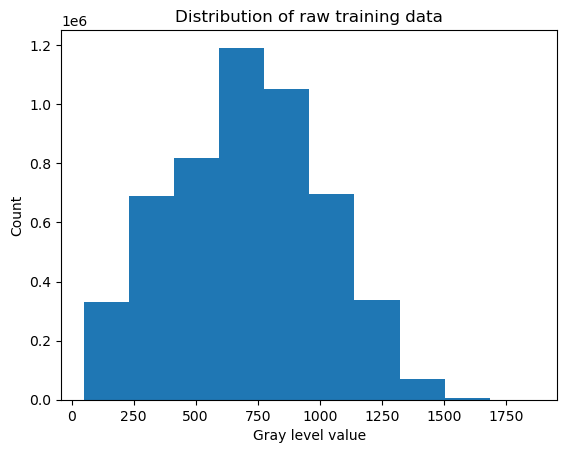

NormaltestResult(statistic=array([194304.81035592]), pvalue=array([0.]))


In [5]:
# Looking at the shape of the training data, to decide how to scale the data
# The test data should not be used for this to avoid data leakage (as the decision process is a form of learning, even though it is human and not machine!)
fig = plt.subplots()
plt.hist(values_train_raw.ravel())
plt.xlabel("Gray level value")
plt.ylabel("Count")
plt.title("Distribution of raw training data")
plt.show()

print(normaltest(values_train_raw))

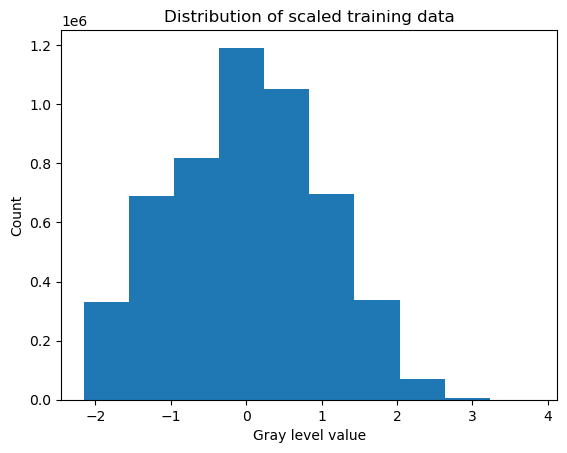

In [6]:
# The data seems to follow a normal distrubtion, therefore using standard scaling / z-score normalizing
# which centers the data to zero and scales to a standard deviation of 1
scaler_image = StandardScaler()
values_train = scaler_image.fit_transform(values_train_raw) # Only fit to training data
values_test = scaler_image.transform(values_test_raw)

fig = plt.subplots()
plt.hist(values_train.ravel())
plt.xlabel("Gray level value")
plt.ylabel("Count")
plt.title("Distribution of scaled training data")
plt.show()

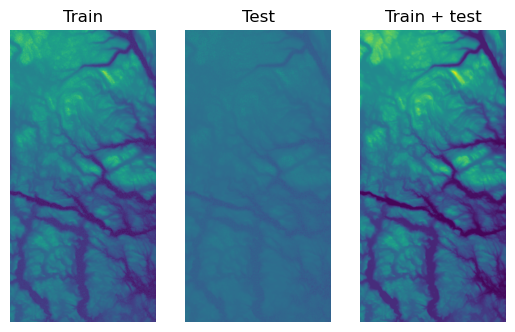

In [7]:
# Validating the train / test split visually by plotting images separately and combined
img_train = np.empty(shape=len(index_vals))
img_test = np.empty(shape=len(index_vals))

img_train[idx_train] = values_train.ravel()
img_test[idx_test] = values_test.ravel()

img_train = img_train.reshape(terrain1.shape)
img_test = img_test.reshape(terrain1.shape)

fig, ax = plt.subplots(ncols=3)
ax[0].imshow(img_train)
ax[0].set_title("Train")
ax[1].imshow(img_test)
ax[1].set_title("Test")
ax[2].imshow(img_train + img_test)
ax[2].set_title("Train + test")
[axi.axis("off") for axi in ax]

plt.show()

In [8]:
# Calculating and normalizing x and y - values,
# using a min-max scaler as each pair of values appear only once - i.e. are uniformly distributed
scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

x_train = scaler_x.fit_transform(x_train.reshape(-1, 1)).reshape(-1)
x_test = scaler_x.transform(x_test.reshape(-1, 1)).reshape(-1)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)

print(x_train.shape, y_train.shape)

(5188320,) (5188320,)


### OLS
Creating the design matrix $X$ with $x$ and $y$ as features up until degree $p$

In [9]:
# Creating design matrix X
# no intercept needed as image gray level data are centered on zero

def create_2d_polynomial_design_matrix(x, y, pmax=5, include_interactions=False):
    # Create design matrix for polynomial up to degree 5, using both x and y as predictors, as [x, y, x^2, y^2, xy, ....]
    # TODO: include interaction terms xy, x^2y, xy^2, etc...
    N = len(x)
    M = 1 + 2 * pmax
    X = np.empty(shape=(N, M))
    m = 0

    for p in range(pmax + 1):
        if p == 0:
            X[:, m] = np.ones(N)    # only need one rows for intercept
            m += 1
        else:
            X[:, m] = x**p
            X[:, m + 1] = y**p
            m += 2
    # print(f"Design matrix of polynomial up to degree {pmax} created:", X.shape)

    return X


def beta_ols_estimation(X, y):
    try:
        X_inv = np.linalg.inv(X.T.dot(X))
    except Exception as e:
        print(*e.args)
        X_inv = np.linalg.pinv(X.T.dot(X))

    betas = X_inv.dot(X.T).dot(y)
    return betas


scores = pd.DataFrame(dtype=float)

for p in range(10):
    # Big X = design matrix
    X_train = create_2d_polynomial_design_matrix(x_train, y_train, pmax=p)
    X_test = create_2d_polynomial_design_matrix(x_test, y_test, pmax=p)
    
    betas = beta_ols_estimation(X_train, values_train)
    zhat_train = X_train @ betas
    zhat_test = X_test @ betas
    
    r2_train, r2_test = r2_score(values_train, zhat_train), r2_score(values_test, zhat_test)
    mse_train, mse_test = mean_squared_error(values_train, zhat_train), mean_squared_error(values_test, zhat_test)

    print(f"p={p}\t r2 train / test = {r2_train:.3e} / {r2_test:.3e}\t mse = {mse_train:.3e} / {mse_test:.3e}")
    scores.loc[p, ["r2_train", "r2_test", "mse_train", "mse_test"]] = [r2_train, r2_test, mse_train, mse_test]

print(scores)

p=0	 r2 train / test = 0.000e+00 / -1.220e-07	 mse = 1.000e+00 / 1.001e+00
p=1	 r2 train / test = 3.448e-01 / 3.452e-01	 mse = 6.552e-01 / 6.554e-01
p=2	 r2 train / test = 3.672e-01 / 3.677e-01	 mse = 6.328e-01 / 6.329e-01
p=3	 r2 train / test = 3.816e-01 / 3.821e-01	 mse = 6.184e-01 / 6.184e-01
p=4	 r2 train / test = 3.885e-01 / 3.890e-01	 mse = 6.115e-01 / 6.115e-01
p=5	 r2 train / test = 3.924e-01 / 3.930e-01	 mse = 6.076e-01 / 6.075e-01
p=6	 r2 train / test = 3.958e-01 / 3.966e-01	 mse = 6.042e-01 / 6.040e-01
p=7	 r2 train / test = 3.984e-01 / 3.992e-01	 mse = 6.016e-01 / 6.014e-01
p=8	 r2 train / test = 4.000e-01 / 4.008e-01	 mse = 6.000e-01 / 5.997e-01
p=9	 r2 train / test = 4.034e-01 / 4.043e-01	 mse = 5.966e-01 / 5.963e-01
   r2_train       r2_test  mse_train  mse_test
0  0.000000 -1.220470e-07   1.000000  1.000949
1  0.344845  3.452072e-01   0.655155  0.655414
2  0.367227  3.677495e-01   0.632773  0.632850
3  0.381623  3.821422e-01   0.618377  0.618444
4  0.388453  3.890383e-0

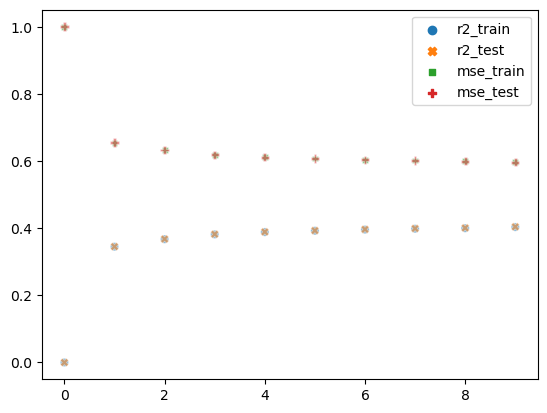

In [10]:
import seaborn as sns
sns.scatterplot(scores, alpha=0.5)
plt.show()

There is no discernable difference between train and test scores.
As the test set contains random pixels form the image, and are surrounded by pixels of very similar values, this task may have been to easy to inferr the correct values.
Instead of choosing test pixels at random, the image is now divided into two chunks for train / testing:

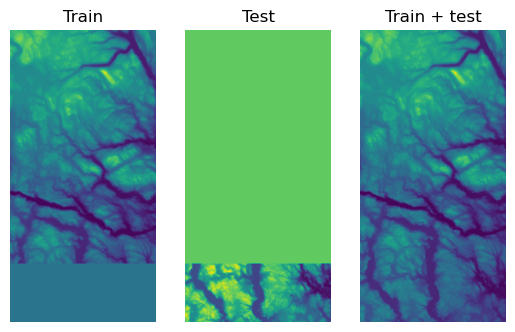

In [11]:
idx_train = index_vals[:int(len(index_vals) * 0.80)]
idx_test = index_vals[max(idx_train)+1:]

scaler = StandardScaler()
values_train = scaler.fit_transform(terrain1_values[idx_train].reshape(-1, 1))
values_test = scaler.transform(terrain1_values[idx_test].reshape(-1, 1))


x_train = idx_train.reshape(-1, 1) % terrain1.shape[0]
y_train = idx_train.reshape(-1, 1) // terrain1.shape[0]
x_test = idx_test.reshape(-1, 1) % terrain1.shape[0]
y_test = idx_test.reshape(-1, 1) // terrain1.shape[0]


scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler_x.fit_transform(x_train).reshape(-1)
x_test = scaler_x.transform(x_test).reshape(-1)
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)


img_train = np.empty(shape=len(index_vals))
img_test = np.empty(shape=len(index_vals))

img_train[idx_train] = values_train.ravel()
img_test[idx_test] = values_test.ravel()

img_train = img_train.reshape(terrain1.shape)
img_test = img_test.reshape(terrain1.shape)

fig, ax = plt.subplots(ncols=3)
ax[0].imshow(img_train)
ax[0].set_title("Train")
ax[1].imshow(img_test)
ax[1].set_title("Test")
ax[2].imshow(img_train + img_test)
ax[2].set_title("Train + test")
[axi.axis("off") for axi in ax]

plt.show()

In [12]:
scores = pd.DataFrame(dtype=float)
for p in range(1, 10):
    # Big X = design matrix
    X_train = create_2d_polynomial_design_matrix(x_train, y_train, pmax=p)
    X_test = create_2d_polynomial_design_matrix(x_test, y_test, pmax=p)
    
    betas = beta_ols_estimation(X_train, values_train)
    zhat_train = X_train @ betas
    zhat_test = X_test @ betas
    
    r2_train, r2_test = r2_score(values_train, zhat_train), r2_score(values_test, zhat_test)
    mse_train, mse_test = mean_squared_error(values_train, zhat_train), mean_squared_error(values_test, zhat_test)

    print(f"p={p}\t r2 train / test = {r2_train:.3e} / {r2_test:.3e}\t mse = {mse_train:.3e} / {mse_test:.3e}")
    scores.loc[p, ["r2_train", "r2_test", "mse_train", "mse_test"]] = [r2_train, r2_test, mse_train, mse_test]


p=1	 r2 train / test = 3.404e-01 / -6.844e-01	 mse = 6.596e-01 / 7.214e-01
p=2	 r2 train / test = 3.419e-01 / -3.371e-01	 mse = 6.581e-01 / 5.727e-01
p=3	 r2 train / test = 3.708e-01 / -3.454e+00	 mse = 6.292e-01 / 1.907e+00
p=4	 r2 train / test = 3.773e-01 / -1.661e+01	 mse = 6.227e-01 / 7.544e+00
p=5	 r2 train / test = 3.780e-01 / -2.876e+01	 mse = 6.220e-01 / 1.275e+01
p=6	 r2 train / test = 3.830e-01 / -1.021e+01	 mse = 6.170e-01 / 4.799e+00
p=7	 r2 train / test = 3.961e-01 / -2.768e+03	 mse = 6.039e-01 / 1.186e+03
p=8	 r2 train / test = 3.991e-01 / -1.249e+04	 mse = 6.009e-01 / 5.348e+03
p=9	 r2 train / test = 4.108e-01 / -3.151e+04	 mse = 5.892e-01 / 1.350e+04


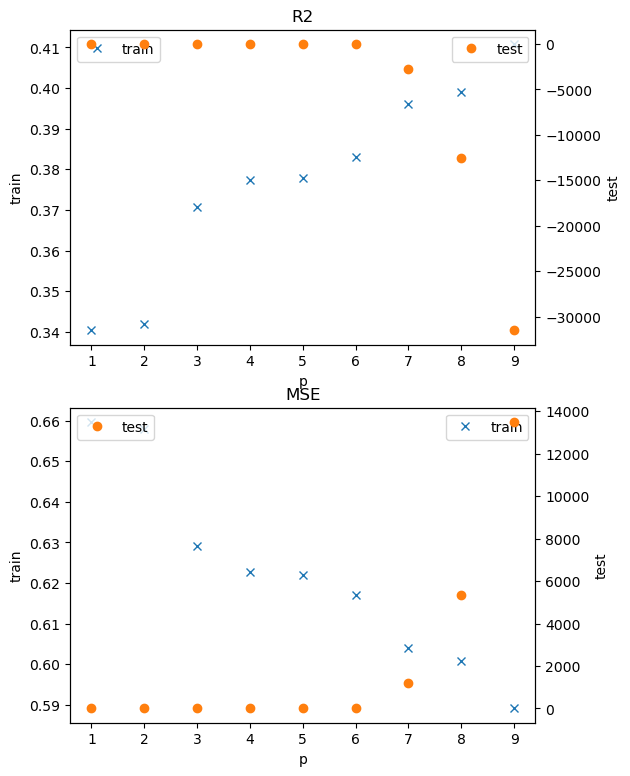

In [13]:
import seaborn as sns
pvalues = list(range(1, 10))
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 9))

ax1.set_title("R2")
ax1.plot(pvalues, scores["r2_train"], "x", label="train")
ax11 = ax1.twinx()
ax11.plot(pvalues, scores["r2_test"], "o", label="test", c="C1")

ax2.set_title("MSE")
ax2.plot(pvalues, scores["mse_train"], "x", label="train")
ax21 = ax2.twinx()
ax21.plot(pvalues, scores["mse_test"], "o", label="test", c="C1")


ax1.set_ylabel("train")
ax2.set_ylabel("train")
ax11.set_ylabel("test")
ax21.set_ylabel("test")
[ax.legend() for ax in [ax1, ax11, ax2, ax21]]
[ax.set_xlabel("p") for ax in [ax1, ax2]]
#ax1.set_yscale("log")
#ax2.set_yscale("log")
#ax21.set_yscale("log")

#sns.scatterplot(scores[["r2_train", "r2_test"]], alpha=0.5)
#plt.yscale("log")
plt.show()

We now see a clear trend of increased overfitting to the training data by increasing $p$, causing the test metrics to blow up in positive / negative direction for MSE / R2 respectively.

## Adding Ridge and Lasso penalization

In [20]:
from sklearn.linear_model import Ridge, Lasso

pvals = list(range(1, 5))
avals = [1, 2, 3]

# mse_train_vals = np.ones((len(pvals), len(avals))
mse_test_vals_1 = np.ones(shape=(len(pvals), len(avals)))
mse_test_vals_2 = np.ones(shape=(len(pvals), len(avals)))

                        
for i, p in enumerate(pvals):
    X_train = create_2d_polynomial_design_matrix(x_train, y_train, pmax=p)
    X_test = create_2d_polynomial_design_matrix(x_test, y_test, pmax=p)
    for j, a in enumerate(avals):
        print(p, a, end="\t")
        m1 = Ridge(alpha=a, fit_intercept=False)
        m2 = Lasso(alpha=a, fit_intercept=False)
        m1.fit(X_train, values_train)
        m2.fit(X_train, values_train)

        zhat_test_1 = m1.predict(X_test)
        zhat_test_2 = m2.predict(X_test)

        mse_test_1, mse_test_2 = mean_squared_error(values_test, zhat_test_1), mean_squared_error(values_test, zhat_test_2)
        print(mse_test_1, mse_test_2)
        
        mse_test_vals_1[i, j] = mse_test_1
        mse_test_vals_2[i, j] = mse_test_2


1 1	0.7214077347640102 0.9811328213948302
1 2	0.7214069520754418 0.9811328213948302
1 3	0.7214061693888536 0.9811328213948302
2 1	0.5726795873296853 0.9811328213948302
2 2	0.5726793206419789 0.9811328213948302
2 3	0.5726790539538695 0.9811328213948302
3 1	1.907332043785112 0.9811328213948302
3 2	1.9072728548246618 0.9811328213948302
3 3	1.9072136684542558 0.9811328213948302
4 1	7.543438434608421 0.9811328213948302
4 2	7.542905553711196 0.9811328213948302
4 3	7.542372742931258 0.9811328213948302


(4, 3)


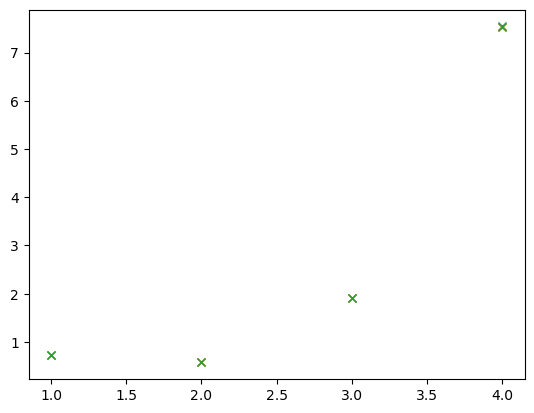

In [27]:
print(mse_test_vals_1.shape)
plt.figure()
for j in range(mse_test_vals_1.shape[1]):
    a = avals[j]
    plt.plot(pvals, mse_test_vals_1[:, j], "x", label=f"idge $\alpha$={a:.1f}")

#plt.legend()
plt.show()